In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.utils.data import download_file

In [5]:
from bs4 import BeautifulSoup

bs = BeautifulSoup(open(download_file('http://svo2.cab.inta-csic.es/theory/fps3/fps.php')).read())

/Users/bmmorris/anaconda/lib/python3.5/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /Users/bmmorris/anaconda/lib/python3.5/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


In [79]:
all_options = [b.attrs['value'] for b in bs.find_all('option')]
instruments = all_options[1:all_options.index('', 1)]
facilities = all_options[all_options.index('', 1)+1:all_options.index('', 150)]
photometric_system = all_options[all_options.index('', 150)+1:]

In [ ]:
from astropy.table import Table

bessel_filters = Table.read(download_file('http://svo2.cab.inta-csic.es/theory/fps3/fps.php?PhotSystem=Bessell'), format='votable')
bessel_links = [i for i in filters['TrasmissionCurve'] if 'Generic' in str(i)]

In [369]:
include_facilities = ['2MASS', 'SLOAN', 'Kepler', 'TESS']

In [370]:
filters = [Table.read(download_file('http://svo2.cab.inta-csic.es/theory/fps3/fps.php?Facility={0}'.format(facility)), format='votable')
           for facility in include_facilities]
links = [[i for i in filt['TrasmissionCurve']] 
         for filt in filters]
print(links)

/Users/bmmorris/anaconda/lib/python3.5/site-packages/astropy/io/votable/tree.py:3366: W42: /var/folders/b3/hq8c10h90xdc3mxwlk53tvzm0000gn/T/tmpq5cod5s5:2:0: W42: No XML namespace specified
  vo_warn(W42, (), config, pos)
/Users/bmmorris/anaconda/lib/python3.5/site-packages/astropy/io/votable/tree.py:3366: W42: /var/folders/b3/hq8c10h90xdc3mxwlk53tvzm0000gn/T/tmpdff9i4z7:2:0: W42: No XML namespace specified
  vo_warn(W42, (), config, pos)
/Users/bmmorris/anaconda/lib/python3.5/site-packages/astropy/io/votable/tree.py:3366: W42: /var/folders/b3/hq8c10h90xdc3mxwlk53tvzm0000gn/T/tmpwi808rdn:2:0: W42: No XML namespace specified
  vo_warn(W42, (), config, pos)


[[b'http://svo2.cab.inta-csic.es//theory/fps3/fps.php?ID=2MASS/2MASS.J', b'http://svo2.cab.inta-csic.es//theory/fps3/fps.php?ID=2MASS/2MASS.H', b'http://svo2.cab.inta-csic.es//theory/fps3/fps.php?ID=2MASS/2MASS.Ks'], [b'http://svo2.cab.inta-csic.es//theory/fps3/fps.php?ID=SLOAN/SDSS.uprime_filter', b'http://svo2.cab.inta-csic.es//theory/fps3/fps.php?ID=SLOAN/SDSS.u', b'http://svo2.cab.inta-csic.es//theory/fps3/fps.php?ID=SLOAN/SDSS.g', b'http://svo2.cab.inta-csic.es//theory/fps3/fps.php?ID=SLOAN/SDSS.gprime_filter', b'http://svo2.cab.inta-csic.es//theory/fps3/fps.php?ID=SLOAN/SDSS.r', b'http://svo2.cab.inta-csic.es//theory/fps3/fps.php?ID=SLOAN/SDSS.rprime_filter', b'http://svo2.cab.inta-csic.es//theory/fps3/fps.php?ID=SLOAN/SDSS.i', b'http://svo2.cab.inta-csic.es//theory/fps3/fps.php?ID=SLOAN/SDSS.iprime_filter', b'http://svo2.cab.inta-csic.es//theory/fps3/fps.php?ID=SLOAN/SDSS.z', b'http://svo2.cab.inta-csic.es//theory/fps3/fps.php?ID=SLOAN/SDSS.zprime_filter'], [b'http://svo2.cab.in

/Users/bmmorris/anaconda/lib/python3.5/site-packages/astropy/io/votable/tree.py:3366: W42: /var/folders/b3/hq8c10h90xdc3mxwlk53tvzm0000gn/T/tmpxnhtn_mr:2:0: W42: No XML namespace specified
  vo_warn(W42, (), config, pos)


In [371]:
tables = dict()
for facility_links in links: 
    for link in facility_links:
        name = link.decode().split('=')[1]
        tables[name] = Table.read(download_file(link.decode()))

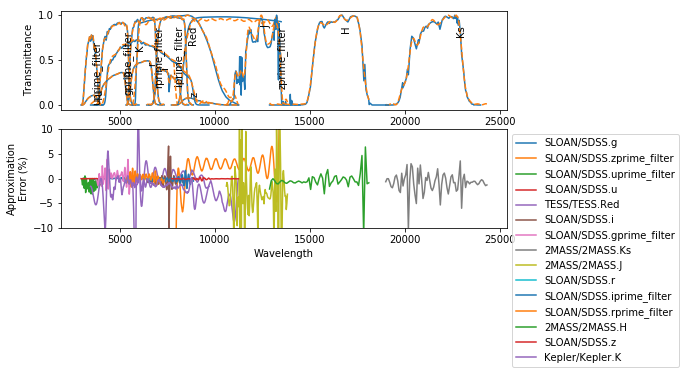

In [372]:
rows = dict()
n_terms = 12

fig, ax = plt.subplots(2, 1, figsize=(8, 4))

for k, v in tables.items(): 
    
    wl, tr = v['Wavelength'], v['Transmission']
    
    ax[0].plot(wl, tr, label=k, color='C0')

    delta_lambda = np.median(np.diff(wl))
    lambda_0 = wl.min()
    n_lambda = len(wl)
    
    simplified_wavelength = np.arange(lambda_0, (n_lambda + 1) * delta_lambda + lambda_0, delta_lambda)
    
    tr_max = tr.max()
    fft = np.fft.fft(np.interp(simplified_wavelength, wl, tr))
    ifft = np.fft.ifft(fft[:n_terms], n=len(simplified_wavelength))
    ifft_real = ifft.real
    normalized_fft = (ifft_real - ifft_real.min()) * tr_max / ifft_real.ptp()
    
    ax[0].plot(simplified_wavelength, normalized_fft, ls='--', label=k+' fft', color='C1')

    ax[0].annotate(k.split('.')[1], rotation=90,
                   xy=(simplified_wavelength[np.argmax(normalized_fft)], 0.8 * normalized_fft.max()))
    
    ax[1].plot(simplified_wavelength, 100*(np.interp(simplified_wavelength, wl, tr) - normalized_fft), label=k)
    row = [n_lambda, lambda_0, delta_lambda, tr_max] + fft[:n_terms].tolist()
    rows[k] = row 
    
ax[0].set_ylabel('Transmittance')
ax[1].set_ylabel('Approximation\nError (%)')
ax[-1].set_xlabel('Wavelength')
ax[1].set_ylim([-10, 10])
ax[1].legend(bbox_to_anchor=(1, 0., 0., 1))
# plt.savefig('tmp/error.png', bbox_inches='tight', dpi=200)

In [373]:
bt = fits.BinTableHDU(Table(rows))

In [374]:
bt.writeto('tynt/data/fft.fits', overwrite=True)

In [375]:
!ls -lh tynt/data/fft.fits

-rw-r--r--  1 bmmorris  staff    14K Jun 11 15:16 tynt/data/fft.fits


In [368]:
def reconstruct(bt, identifier):
    filt = bt.data[identifier]
    n_lambda, lambda_0, delta_lambda, tr_max = filt[:4].real
    fft = filt[4:]

    wavelength = np.arange(lambda_0, (n_lambda + 1) * delta_lambda + lambda_0, delta_lambda)
    
    ifft = np.fft.ifft(fft[:n_terms], n=len(wl))

    flux = (ifft.real - ifft.real.min()) * tr_max / ifft.real.ptp()
    
    return wavelength, flux
    
identifier = 'Generic/Bessell.B'

wl, tr = reconstruct(bt, identifier)

plt.plot(wl, tr)

KeyError: "Key 'Generic/Bessell.B' does not exist."